In [1]:
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import tqdm
import sys
import pickle
import PyComplexHeatmap as pch
import scvi
import IPython
import pandas as pd

sc.settings.figdir=os.path.expanduser('~/WbFigures/DevSignaling')
sc._settings.settings._vector_friendly=True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis


import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/antipode/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is not available


In [14]:
adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets.h5ad'))

In [3]:
adata

AnnData object with n_obs × n_vars = 1913938 × 16738 backed at '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets.h5ad'
    obs: 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'clean_cellname', 'full_cellname', 'msregion', 'general_region', 'species', 'percent_ribo', 'n_counts', 'log10_n_counts', 'individual', 'singlet', 'doublet', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'highly_variable_rank', 'variances', 'variances_norm', 'means'
    uns: 'general_region_color_dict', 'general_region_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'region_cats', 'region_colors', 'region_colors_dict', 'species_color_dict', 'species_colors', 'umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [4]:
region_means = antipode.model_functions.group_aggr_anndata(adata,category_column_names=['region','phase','species'],normalize=True,layer='spliced')

100%|██████████| 270/270 [03:53<00:00,  1.15it/s]


In [5]:
region_means

(array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [4.14702772e-05, 1.06031675e-05, 2.41509770e-05, ...,
           2.31104477e-05, 0.00000000e+00, 2.13281442e-06],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [3.59172336e-05, 9.44415751e-06, 2.52447571e-05, ...,
           1.54184199e-05, 2.19665125e-07, 7.85348448e-07],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [2.79854557e-05, 7.26281178e-06, 2.75348521e-05, ...,
           1.46853481e-05, 0.00000000e+00, 1.00488103e-06],
  

In [34]:
adata

AnnData object with n_obs × n_vars = 1913938 × 16738
    obs: 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'clean_cellname', 'full_cellname', 'msregion', 'general_region', 'species', 'percent_ribo', 'n_counts', 'log10_n_counts', 'individual', 'singlet', 'doublet', 'S_score', 'G2M_score', 'phase', 'level_2', 'neighborhood', 'curated_class_label'
    var: 'n_cells', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'highly_variable_rank', 'variances', 'variances_norm', 'means'
    uns: 'general_region_color_dict', 'general_region_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'region_cats', 'region_colors', 'region_colors_dict', 'species_color_dict', 'species_colors', 'umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [28]:
adata.obs.index = adata.obs.index.str.replace('-[0-9]+$','',regex=True).str.replace('-[0-9]+$','',regex=True)
curateds=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/annotations/curated_class.txt',index_col=0)
adata.obs.loc[:,curateds.columns]=curateds.astype('string')


In [47]:
curateds['curated_class_label'].value_counts()

curated_class_label
Ctx IT                281270
Progen Cycling        188803
Progen RG             132511
Ctx IPC Glut          123758
MGE Ctx Gaba           99219
Astro                  97145
DE-ME Glut             95726
Ctx DL                 63879
CGE Ctx Gaba           61298
Ctx Hip                60750
RE_ATOH1_Granule       53453
DE-ME Gaba             49519
Progen OPC             47281
Progen GE              46783
Mesenchyme             38002
Progen Astro-OPC       37485
LGE SPN                34008
Ependymal              25165
Endothelial            22202
MG                     21882
LGE MEIS2 PAX6         21451
RE Gaba                21171
Hypo Gaba              20545
Progen ME Glut         19795
RE Gly                 16824
RE Glut                15838
Pericyte               14978
Bergmann Glia          14936
VMF Glut               14315
ABC                    14126
Placode                13084
LGE FOXP2 TSHZ1        12733
Oligo-Schwann          12459
Hypo Glut              

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/antipode/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


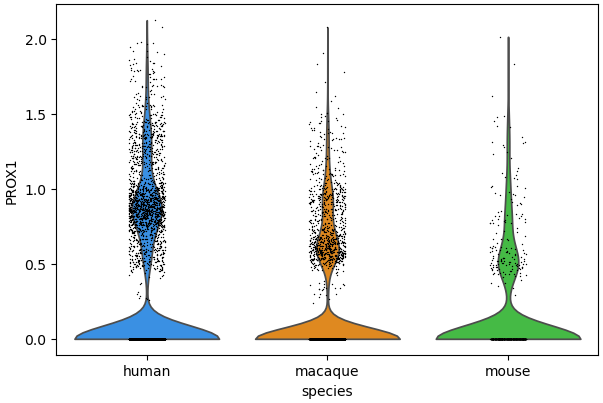

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/antipode/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


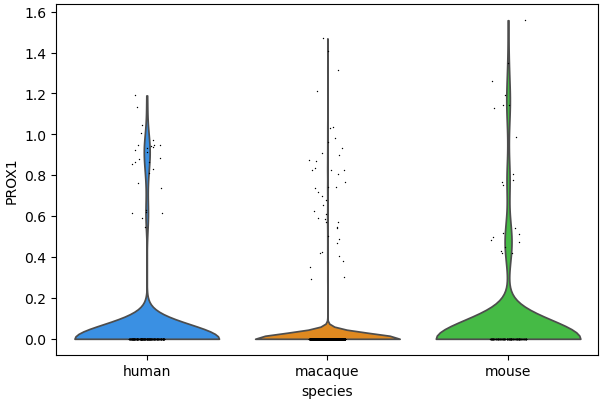

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/antipode/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


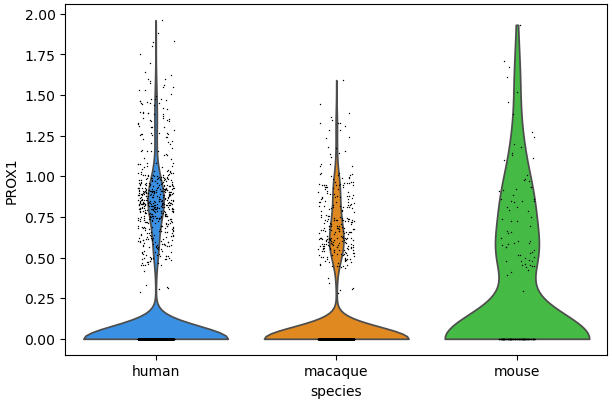

In [50]:
sc.pl.violin(adata[list((adata.obs['region']=='CGE')&(adata.obs['curated_class_label']=='CGE Ctx Gaba')),:],groupby='species',keys=['PROX1'])
sc.pl.violin(adata[list((adata.obs['region']=='CGE')&(adata.obs['curated_class_label']=='LGE FOXP2 TSHZ1')),:],groupby='species',keys=['PROX1'])
sc.pl.violin(adata[list((adata.obs['region']=='CGE')&(adata.obs['curated_class_label']=='LGE MEIS2 PAX6')),:],groupby='species',keys=['PROX1'])

In [ ]:
sc.pl.violin(adata[list((adata.obs['region']=='CGE')&(adata.obs['curated_class_label']=='CGE Ctx Gaba')),:],groupby='species',keys=['PROX1'])

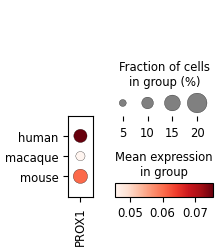

In [9]:
sc.pl.dotplot(adata[(adata.obs['region']=='CGE')&(adata.obs['phase']=='G2M'),:],groupby='species',var_names=['PROX1'])